In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from src.mssm import utils,models

## What are GAMMs

In [23]:
# Generalized additive mixed models are function approximators - they allow
# us to capture non-linear relationships between convariates (including time) and signals.

# Let's build a covariate: time
time = np.array(range(0,3020,20))
time

array([   0,   20,   40,   60,   80,  100,  120,  140,  160,  180,  200,
        220,  240,  260,  280,  300,  320,  340,  360,  380,  400,  420,
        440,  460,  480,  500,  520,  540,  560,  580,  600,  620,  640,
        660,  680,  700,  720,  740,  760,  780,  800,  820,  840,  860,
        880,  900,  920,  940,  960,  980, 1000, 1020, 1040, 1060, 1080,
       1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300,
       1320, 1340, 1360, 1380, 1400, 1420, 1440, 1460, 1480, 1500, 1520,
       1540, 1560, 1580, 1600, 1620, 1640, 1660, 1680, 1700, 1720, 1740,
       1760, 1780, 1800, 1820, 1840, 1860, 1880, 1900, 1920, 1940, 1960,
       1980, 2000, 2020, 2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180,
       2200, 2220, 2240, 2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400,
       2420, 2440, 2460, 2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620,
       2640, 2660, 2680, 2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840,
       2860, 2880, 2900, 2920, 2940, 2960, 2980, 30

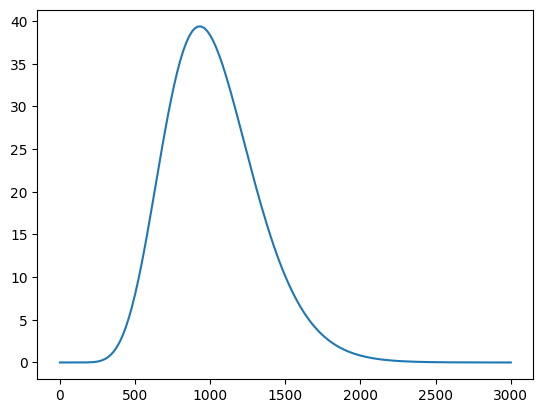

In [24]:
# Let's now define a signal as a function of time!
pulse_loc = [0]
y = utils.h_basis(0,time,pulse_loc,10.1,930,1e-24)
plt.plot(time,y)
plt.show()

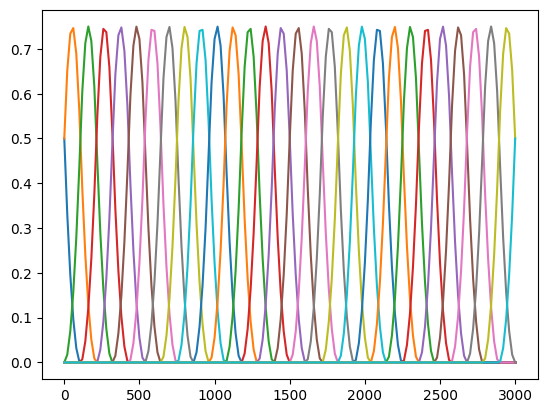

In [25]:
# Now we can use GAMMs to recover that shape.
# First we construct a spline via basis functions.
nk = 30
X = utils.B_spline_basis(0,time,pulse_loc,deg=2,nk=nk,min_c=None,max_c=None,convolve=False,drop_outer_k=False,identifiable=False)

for i in range(X.shape[1]):
    plt.plot(time,X[:,i])
plt.show()

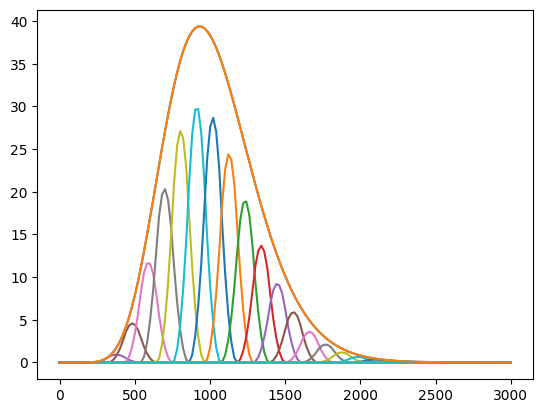

In [26]:
# This is where the magic happens - penalties help us to prevent overfitting.
# Usually we pick too many basis functions and allow the GAMM to penalize those
# away that we don't need.
lTerms = [utils.LambdaTerm(penalties = [utils.diff_pen(nk,3)[0]],start_index=0)]

coef, lambdas, sigma, _ = utils.solve_am(X,y,lTerms,0,maxiter=20)

# Only a small selection of the original basis functions actually contribute to the estimated function!
for i in range(X.shape[1]):
    plt.plot(time,X[:,i]*coef[i])

plt.plot(time,y)
plt.plot(time, X @ coef)
plt.show()

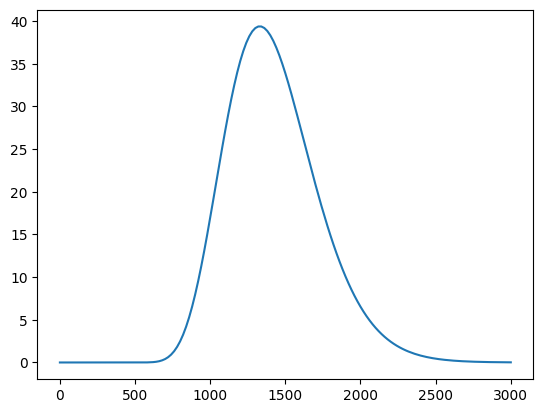

In [27]:
# Now for the DC GAMM, we work with inpulse convolution to time-shift
# splines towards the onset of ``an event`` which influences our signal.

pulse_loc = [20] # Event happens after 20 samples
y = utils.h_basis(0,time,pulse_loc,10.1,930,1e-24)
plt.plot(time,y)
plt.show()

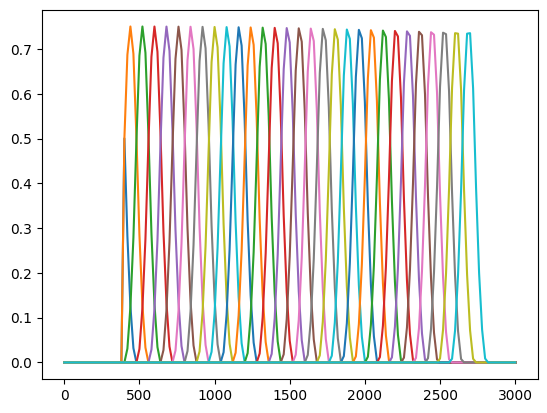

In [28]:
X = utils.B_spline_basis(0,time,pulse_loc,deg=2,nk=nk,min_c=0,max_c=2250,convolve=True,drop_outer_k=False,identifiable=False)

for i in range(X.shape[1]):
    plt.plot(time,X[:,i])
plt.show()

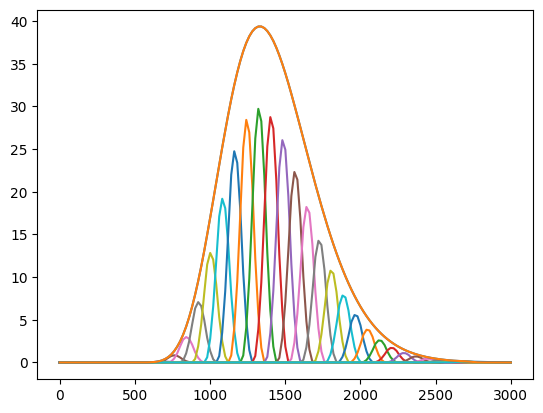

In [29]:
# Reset lambda terms
lTerms = [utils.LambdaTerm(penalties = [utils.diff_pen(nk,3)[0]],start_index=0)]

coef, lambdas, sigma, _ = utils.solve_am(X,y,lTerms,0,maxiter=20)

for i in range(X.shape[1]):
    plt.plot(time,X[:,i]*coef[i])

plt.plot(time,y)
plt.plot(time, X @ coef)
plt.show()